In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score, precision_score, log_loss, accuracy_score, roc_auc_score, confusion_matrix, classification_report
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.preprocessing import (
    MaxAbsScaler,
    MinMaxScaler,
    Normalizer,
    PowerTransformer,
    QuantileTransformer,
    RobustScaler,
    StandardScaler,
    minmax_scale,
)
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.svm import LinearSVC,NuSVC,SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.calibration import CalibratedClassifierCV
from joblib import dump, load
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [2]:
Liver_disease = pd.read_csv('https://raw.githubusercontent.com/MaskiVal/DataSets/main/liver_patient.csv')

In [3]:
Liver_disease.Dataset = Liver_disease.Dataset.apply(lambda x: 0 if x == 2 else x)

In [4]:
Liver_disease.drop_duplicates(inplace=True)
Liver_disease.dropna(inplace=True)

In [6]:
Liver_disease['Gender'] = Liver_disease.Gender.map({'Male':1,'Female':0})

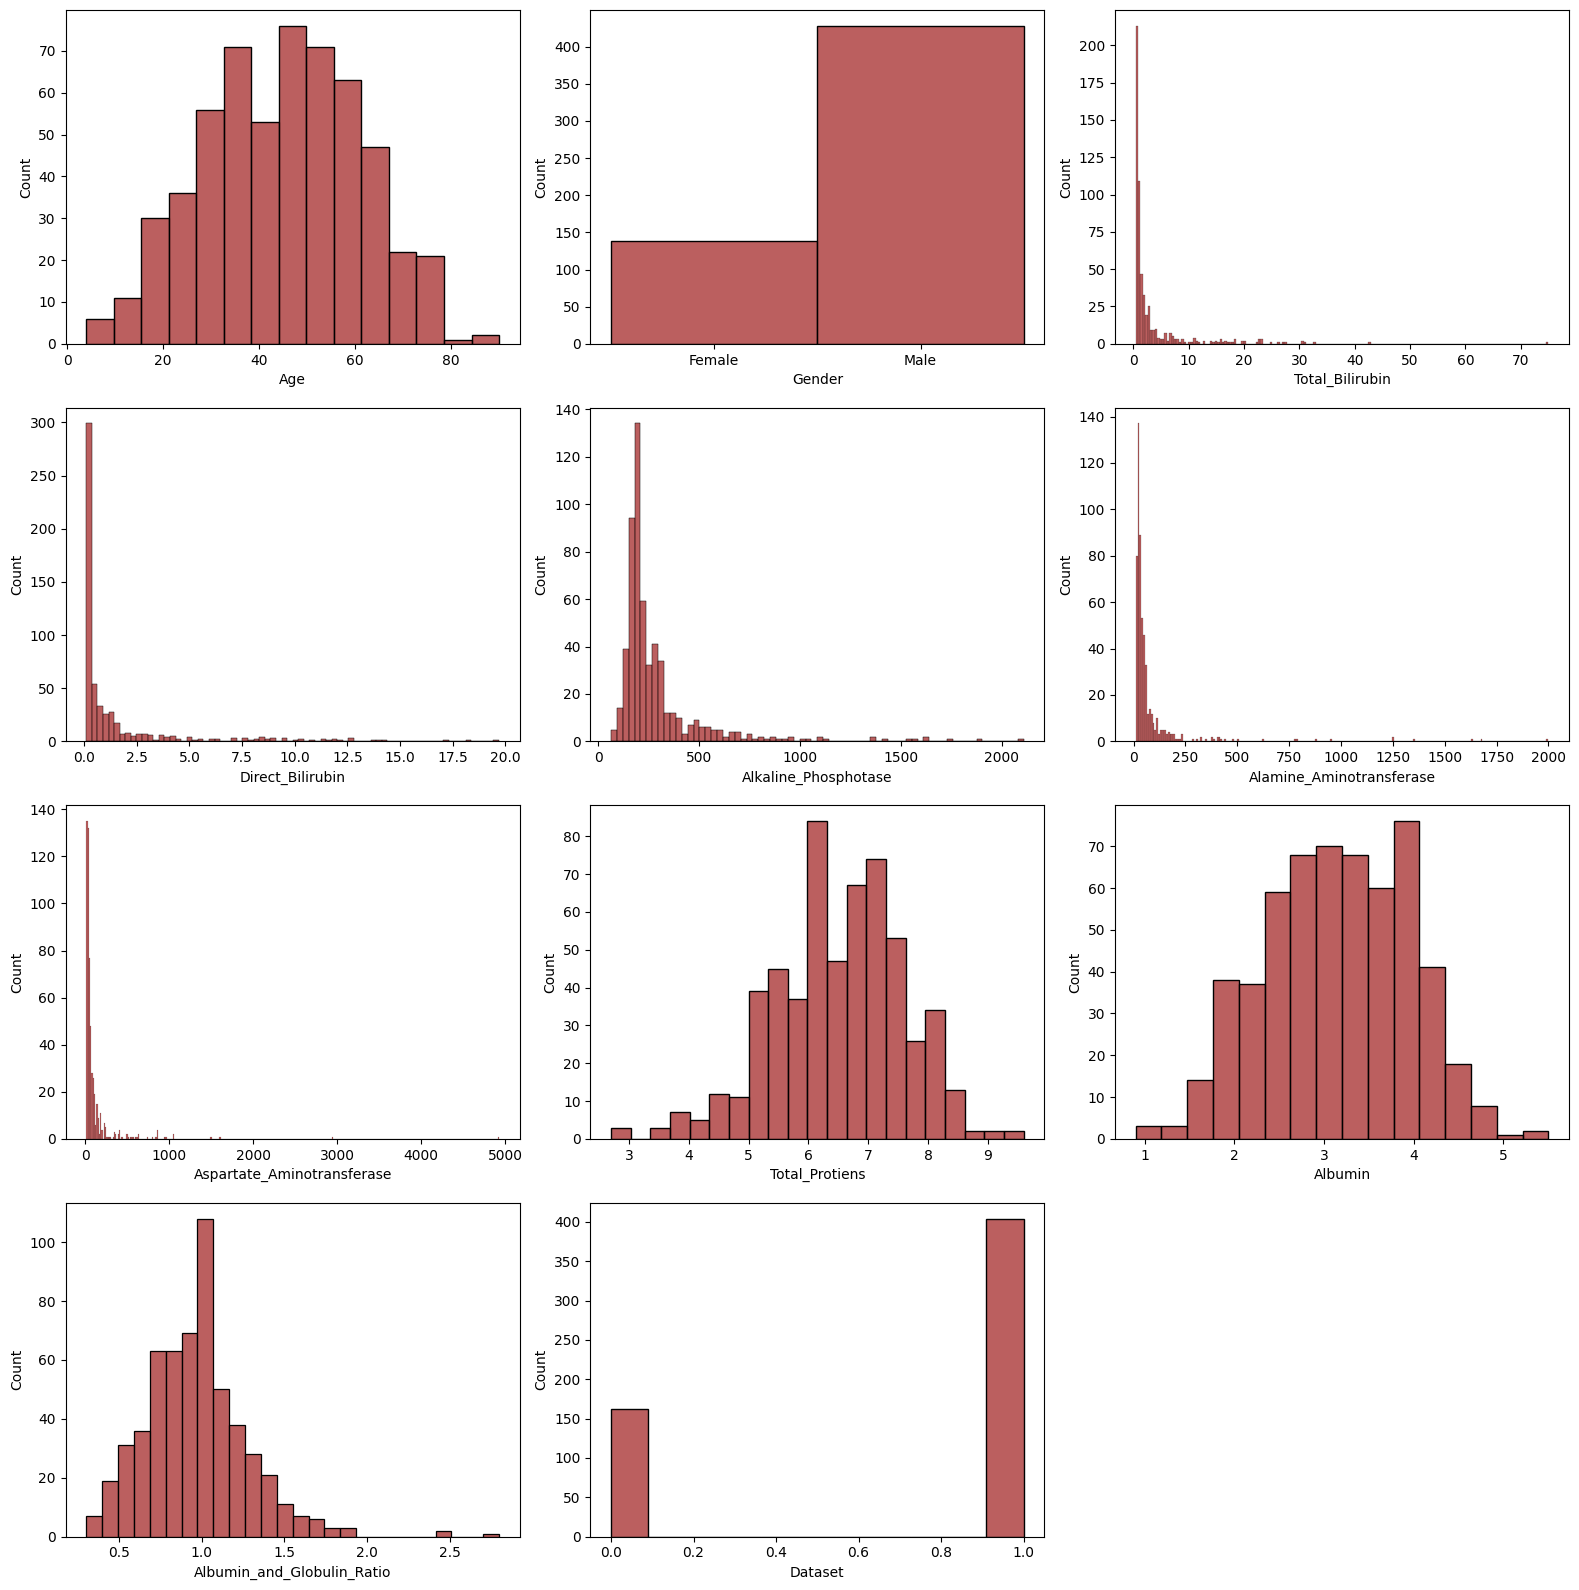

In [ ]:
fig, axes = plt.subplots(4, 3, figsize=(16,16))
for i, ax, column in zip(range(12), axes.flat, Liver_disease.columns):
    sns.histplot(Liver_disease,x=column,ax=ax,color='brown')
plt.tight_layout()
axes.flat[-1].set_visible(False)
plt.show()

In [ ]:
Liver_disease.to_parquet('liver.parquet')

In [13]:
X = Liver_disease.drop(columns=['Direct_Bilirubin','Aspartate_Aminotransferase','Total_Protiens','Albumin','Dataset'])
y = Liver_disease.iloc[:,-1]

Test de la différence avec et sans équilibrage de classes

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create a pipeline with SMOTE and a classifier (Random Forest in this case)
pipeline = make_pipeline(SMOTE(sampling_strategy='auto', random_state=42),
                         StandardScaler(),
                         RandomForestClassifier(random_state=42))

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.45      0.46        49
           1       0.72      0.73      0.72        93

    accuracy                           0.63       142
   macro avg       0.59      0.59      0.59       142
weighted avg       0.63      0.63      0.63       142



In [ ]:
RFC = RandomForestClassifier(random_state=42)
RFC.fit(X_train, y_train)
y_pred_no_smote = RFC.predict(X_test)
print(classification_report(y_test, y_pred_no_smote))

              precision    recall  f1-score   support

           0       0.48      0.20      0.29        49
           1       0.68      0.88      0.77        93

    accuracy                           0.65       142
   macro avg       0.58      0.54      0.53       142
weighted avg       0.61      0.65      0.60       142



In [16]:
classifiers = [
    KNeighborsClassifier(),
    SVC(),
    NuSVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    HistGradientBoostingClassifier(),
    LinearSVC(),
    MLPClassifier(),    
    XGBClassifier(),
    LGBMClassifier(verbose=-1)]

In [17]:
scalers = [
    ("Unscaled data", X),
    ("Data after standard scaling", StandardScaler().fit_transform(X)),
    ("Data after min-max scaling", MinMaxScaler().fit_transform(X)),
    ("Data after max-abs scaling", MaxAbsScaler().fit_transform(X)),
    (
        "Data after robust scaling",
        RobustScaler(quantile_range=(25, 75)).fit_transform(X),
    ),
    (
        "Data after power transformation (Yeo-Johnson)",
        PowerTransformer(method="yeo-johnson").fit_transform(X),
    ),
    (
        "Data after quantile transformation (uniform pdf)",
        QuantileTransformer(
            output_distribution="uniform", random_state=42
        ).fit_transform(X),
    ),
    (
        "Data after quantile transformation (gaussian pdf)",
        QuantileTransformer(
            output_distribution="normal", random_state=42
        ).fit_transform(X),
    ),
    ("Data after sample-wise L2 normalizing", Normalizer().fit_transform(X)),
]

c:\Users\Bamdantag\miniconda3\envs\brandnew\Lib\site-packages\sklearn\preprocessing\_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (566). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\Bamdantag\miniconda3\envs\brandnew\Lib\site-packages\sklearn\preprocessing\_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (566). n_quantiles is set to n_samples.
  warnings.warn(


In [18]:
# Logging for Visual Comparison
log_cols=["Scaler","Classifier", "Recall", "Log Loss"]
log = pd.DataFrame(columns=log_cols)
for X in scalers :
    for clf in classifiers:
        scaler = X[0]
        X_train, X_test, y_train, y_test = train_test_split(X[1], y, random_state=42)
        clf.fit(X_train, y_train)
        name = clf.__class__.__name__

        #print("="*30)
        #print(name)

        #print('****Results****')
        train_predictions = clf.predict(X_test)
        rec = recall_score(y_test, train_predictions)
        #print("Accuracy: {:.4%}".format(acc))
        try:
            train_predictions = clf.predict_proba(X_test)
            ll = log_loss(y_test, train_predictions)
            #print("Log Loss: {}".format(ll))
        except:
            pass
        log_entry = pd.DataFrame([[scaler, name, rec*100, ll]], columns=log_cols)
        log = pd.concat([log,log_entry], ignore_index=True)


C:\Users\Bamdantag\AppData\Local\Temp\ipykernel_23096\3140987198.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log = pd.concat([log,log_entry], ignore_index=True)
c:\Users\Bamdantag\miniconda3\envs\brandnew\Lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
c:\Users\Bamdantag\miniconda3\envs\brandnew\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Bamdantag\miniconda3\envs\brandnew\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: 

In [19]:
log.sort_values(['Recall','Log Loss'],ascending=[False,True]).head(50)

,Scaler,Classifier,Recall,Log Loss
57,Data after max-abs scaling,MLPClassifier,100.000000,0.552726
132,Data after sample-wise L2 normalizing,MLPClassifier,100.000000,0.623703
11,Unscaled data,LinearSVC,100.000000,0.662675
12,Unscaled data,MLPClassifier,100.000000,0.703881
131,Data after sample-wise L2 normalizing,LinearSVC,100.000000,0.744018
61,Data after robust scaling,SVC,100.000000,1.016177
46,Data after max-abs scaling,SVC,100.000000,1.074211
16,Data after standard scaling,SVC,100.000000,1.278939
106,Data after quantile transformation (gaussian pdf),SVC,100.000000,1.286508
31,Data after min-max scaling,SVC,100.000000,1.312653
